# Lymphocytocis classification

__1__ in case of __tumoral__ and __0__ in case of __reactive__ cases

# 1. Read the data

### - read some samples and visualize
This Notebook Has Provided by Imane Si Salah(imane.si_salah@ens-paris-saclay.fr) and Ali Ahmadi (ali.ahmadi@ens-paris-saclay.fr) Master student of MVA for the final project of course Medical Image in Deep learning at MVA ENS Paris Saclay and Central Supelec Universities , March 2024, this challenge was running on Kaggle platform.(https://www.kaggle.com/competitions/dlmi-lymphocytosis-classification).

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import random
from google.colab import drive
import zipfile
from tqdm import tqdm
from collections import Counter

import torch
from torch.utils.data import random_split, DataLoader, Dataset, WeightedRandomSampler, Subset, ConcatDataset
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import balanced_accuracy_score
from collections import Counter


In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/dlmi/dlmi-lymphocytosis-classification.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/data')

there are: 163 patients in the train set and 43 in the test set
images per patient range from 16 images for patient P62 to a max 198 images for patient P35


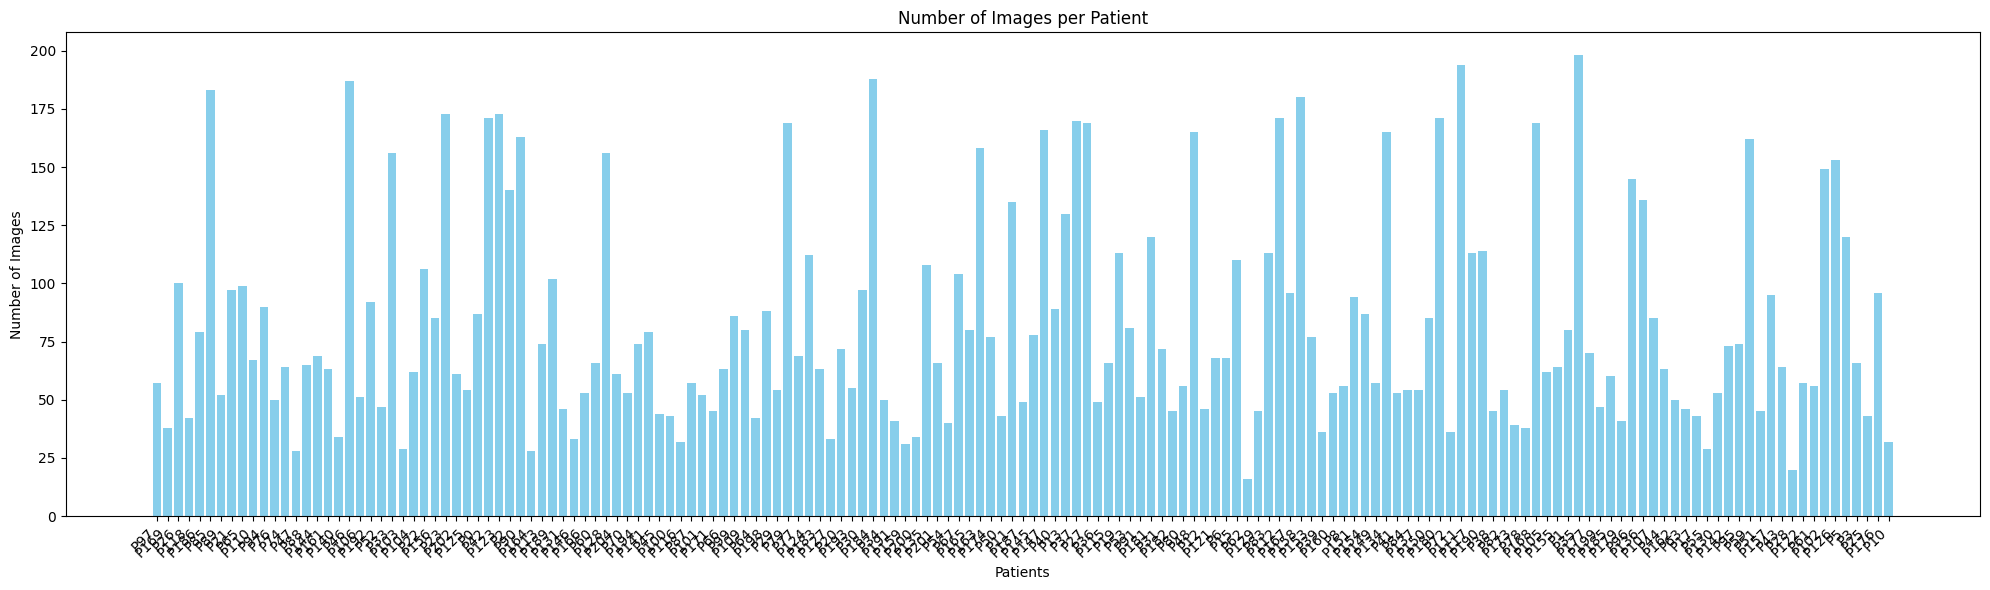

In [ ]:
# read images and labels
train_dir= 'data/trainset'
test_dir= 'data/testset'

train_patients= os.listdir(train_dir)
test_patients= os.listdir(test_dir)

train_patients= [i for i in train_patients if not i.endswith('.csv')]

print(f'there are: {len(train_patients)} patients in the train set and {len(test_patients)} in the test set')

images={}
for patient in train_patients:

    num_images= len(os.listdir(os.path.join(train_dir, patient)))
    images[patient]= num_images


max_patient = max(images, key=images.get)
max_images = images[max_patient]
min_patient = min(images, key=images.get)
min_images = images[min_patient]

print(f'images per patient range from {min_images} images for patient {min_patient} to a max {max_images} images for patient {max_patient}')

# Create bar plot
plt.figure(figsize=(20, 6))
plt.bar(images.keys(), images.values(), color='skyblue')
plt.xlabel('Patients')
plt.ylabel('Number of Images')
plt.title('Number of Images per Patient')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

there is a clear imbalance between how the images are distributed per patiens, next step is to analyse if ther is any class imbalance

do proper data analysis

In [ ]:
train_true = pd.read_csv(os.path.join(train_dir, 'trainset_true.csv'))
train_true.head()

,ID,LABEL,GENDER,DOB,LYMPH_COUNT
0,P26,1,M,11/3/1933,11.2
1,P183,1,M,5/15/1942,12.8
2,P89,1,M,6/19/1935,9.6
3,P123,1,M,1/27/1931,122.6
4,P61,1,F,3/5/1931,11.6


In [ ]:
def extract_year_and_compute_age(dob_str):
    parts = dob_str.replace('-', '/').split('/')
    year_str = parts[-1]
    year = int(year_str)
    current_year = datetime.now().year
    age = current_year - year
    return age

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           163 non-null    object 
 1   LABEL        163 non-null    int64  
 2   GENDER       163 non-null    object 
 3   DOB          163 non-null    object 
 4   LYMPH_COUNT  163 non-null    float64
 5   AGE          163 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 7.8+ KB
None


Class Distribution:
1    113
0     50
Name: LABEL, dtype: int64




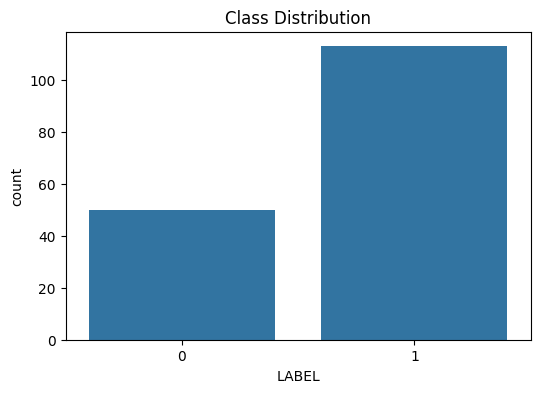

Distribution of GENDER:
M    82
F    80
f     1
Name: GENDER, dtype: int64


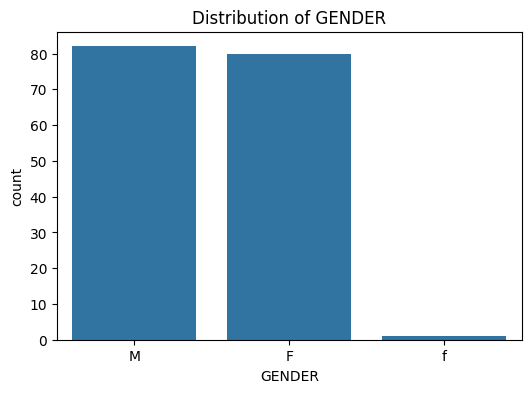

Summary Statistics of LYMPH_COUNT:
count    163.000000
mean      26.423926
std       46.784365
min        2.280000
25%        5.045000
50%        7.810000
75%       20.445000
max      295.000000
Name: LYMPH_COUNT, dtype: float64


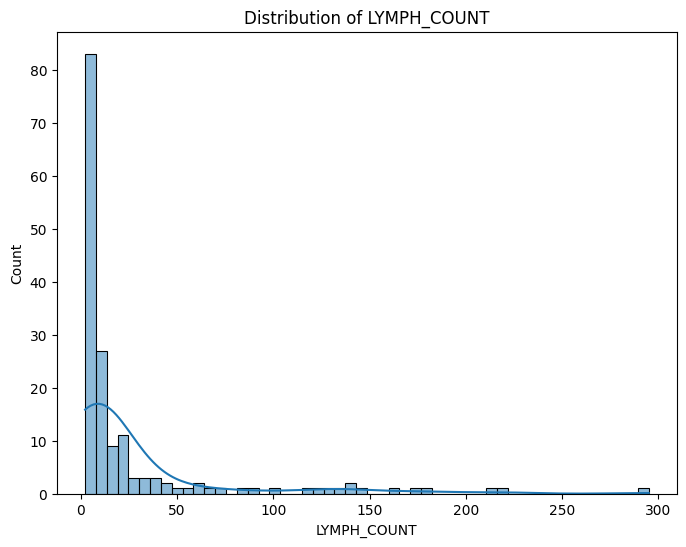

Summary Statistics of Age:
count    163.000000
mean      72.760736
std       17.664862
min       26.000000
25%       64.000000
50%       76.000000
75%       87.500000
max      103.000000
Name: AGE, dtype: float64


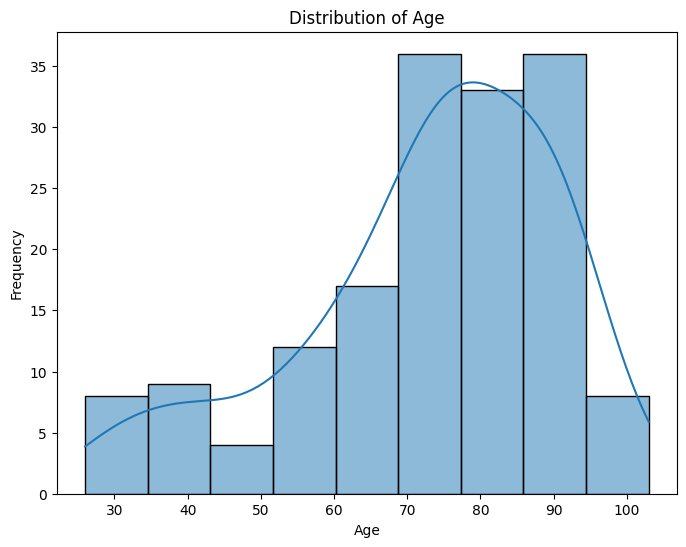

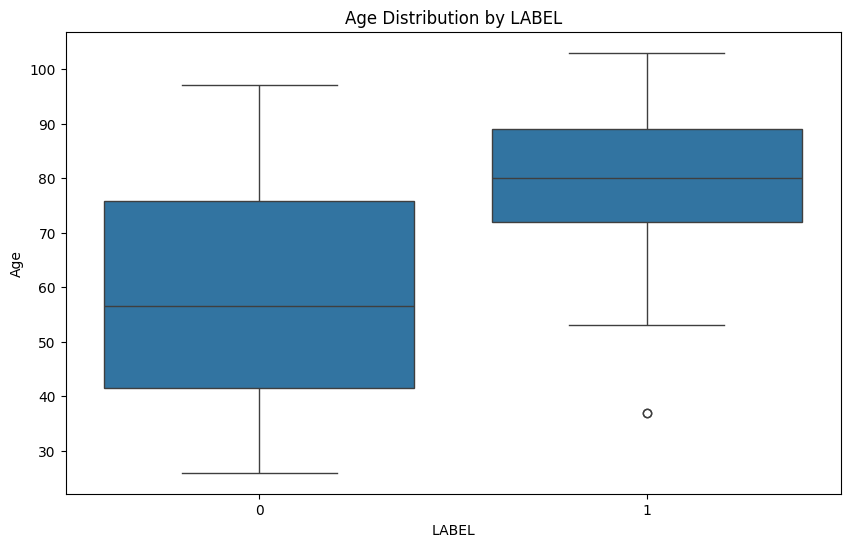

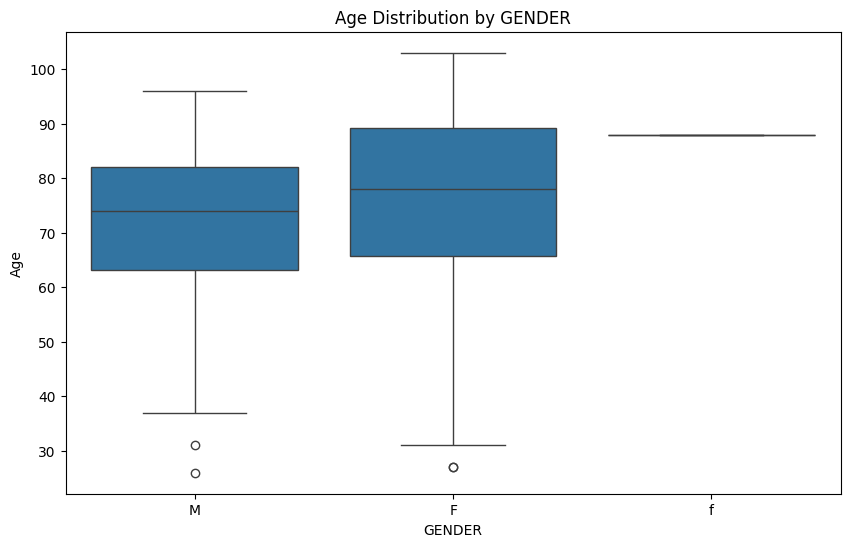

In [ ]:
# Load the labels data
train_true = pd.read_csv(os.path.join(train_dir, 'trainset_true.csv'))



#compute the age of each patient
train_true['AGE'] = train_true['DOB'].apply(extract_year_and_compute_age)


#Basic information
print("Basic Information:")
print(train_true.info())
print("\n")

#Class distribution
class_distribution = train_true['LABEL'].value_counts()
print("Class Distribution:")
print(class_distribution)
print("\n")
plt.figure(figsize=(6, 4))
sns.countplot(x='LABEL', data=train_true)
plt.title("Class Distribution")
plt.show()

#Explore categorical variables
print("Distribution of GENDER:")
print(train_true['GENDER'].value_counts())
plt.figure(figsize=(6, 4))
sns.countplot(x='GENDER', data=train_true)
plt.title("Distribution of GENDER")
plt.show()

#Explore numerical variables
print("Summary Statistics of LYMPH_COUNT:")
print(train_true['LYMPH_COUNT'].describe())
plt.figure(figsize=(8, 6))
sns.histplot(train_true['LYMPH_COUNT'], kde=True)
plt.title("Distribution of LYMPH_COUNT")
plt.show()


##explore age info
print("Summary Statistics of Age:")
print(train_true['AGE'].describe())
plt.figure(figsize=(8, 6))
sns.histplot(train_true['AGE'], kde=True)
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

#Explore relationships between age and other variables
plt.figure(figsize=(10, 6))
sns.boxplot(x='LABEL', y='AGE', data=train_true)
plt.title("Age Distribution by LABEL")
plt.xlabel("LABEL")
plt.ylabel("Age")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='GENDER', y='AGE', data=train_true)
plt.title("Age Distribution by GENDER")
plt.xlabel("GENDER")
plt.ylabel("Age")
plt.show()


In [ ]:
# Assuming 'train_true' DataFrame already contains the 'Age' column
max_age_row_index = train_true['AGE'].idxmax()
corresponding_patient_id = train_true.loc[max_age_row_index, 'ID']

# Filter the DataFrame to get all rows corresponding to the patient with the maximum age
max_age_patient_rows = train_true[train_true['ID'] == corresponding_patient_id]

print("Rows corresponding to the patient with the maximum age:")
print(max_age_patient_rows)


Rows corresponding to the patient with the maximum age:
       ID  LABEL GENDER        DOB  LYMPH_COUNT  AGE
116  P102      1      F  1/27/1921         58.7  103


there is a big class imabalance .. see how to face this later

Sampled patient IDs for class 1: ['P21', 'P79', 'P27']
Sampled patient IDs for class 2: ['P95', 'P198', 'P164']
Patient ID: P21, Class: 1 and has 97 images
Patient ID: P79, Class: 1 and has 169 images
Patient ID: P27, Class: 1 and has 169 images
Patient ID: P95, Class: 0 and has 74 images
Patient ID: P198, Class: 0 and has 88 images
Patient ID: P164, Class: 0 and has 28 images


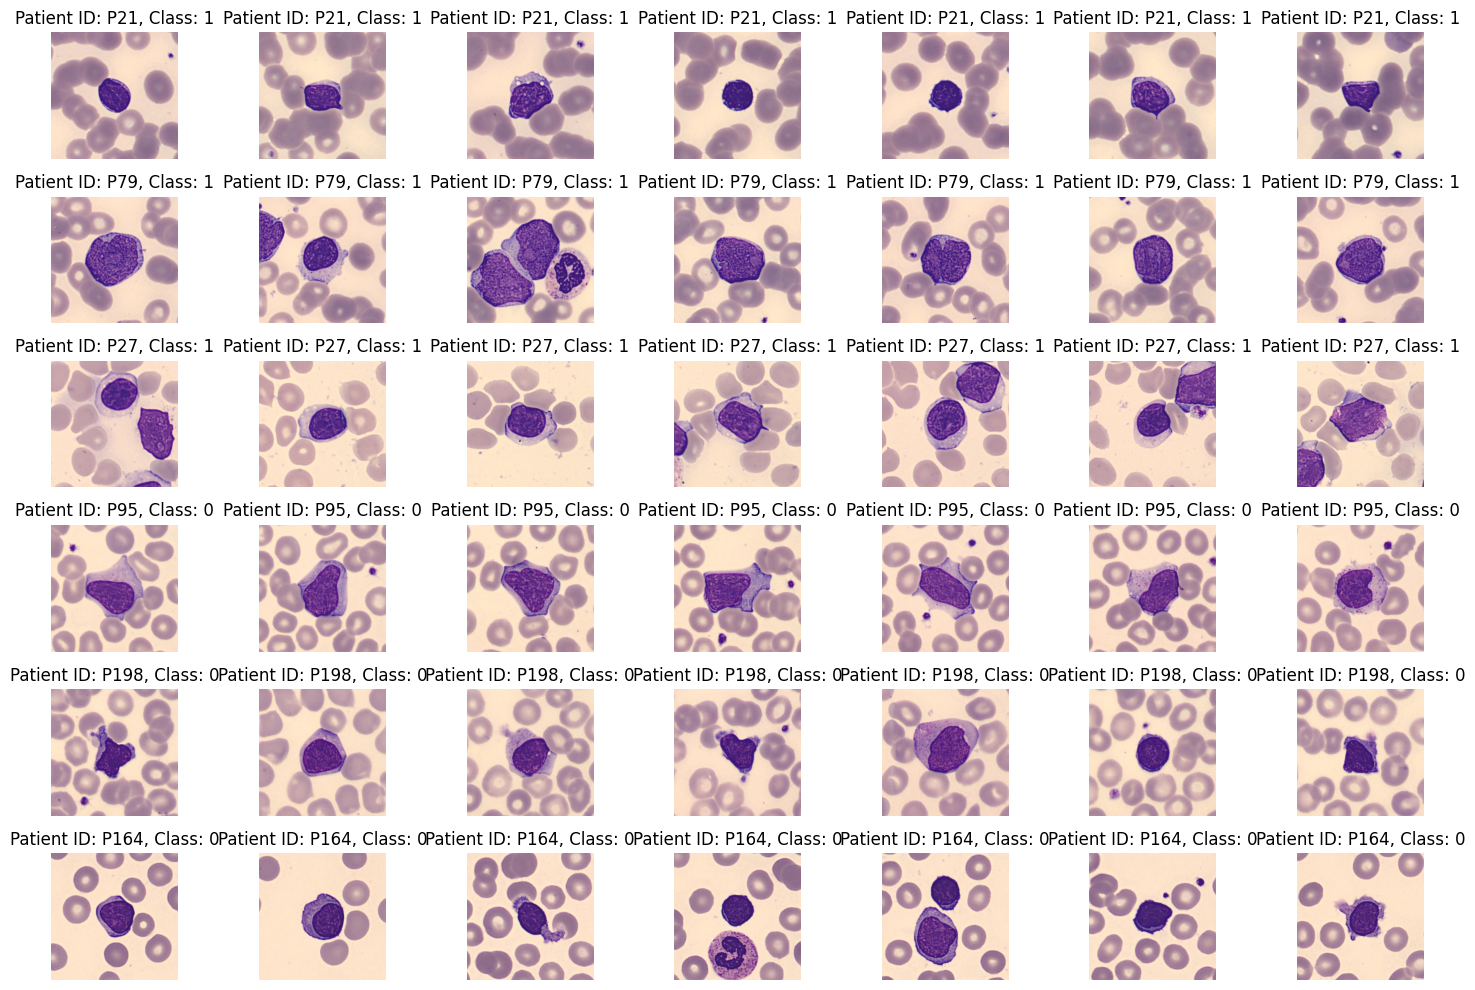

In [ ]:
class_1_ids = train_true[train_true['LABEL'] == 1]['ID'].tolist()
class_1_sample = random.sample(class_1_ids, 3)
class_2_ids = train_true[train_true['LABEL'] == 0]['ID'].tolist()
class_2_sample = random.sample(class_2_ids, 3)

print("Sampled patient IDs for class 1:", class_1_sample)
print("Sampled patient IDs for class 2:", class_2_sample)

fig, axs = plt.subplots(len(class_1_sample + class_2_sample), 7, figsize=(15, 10))

# Iterate through each patient folder
for i, patient_id in enumerate(class_1_sample + class_2_sample):  # Loop through sampled patient IDs
    patient_folder = os.path.join(train_dir, patient_id)
    if not os.path.exists(patient_folder):
        print('not found (bizarre)!!!')
        continue

    # Display patient ID and class
    patient_class = train_true[train_true['ID'] == patient_id]['LABEL'].values[0]
    print(f"Patient ID: {patient_id}, Class: {patient_class} and has {len( os.listdir(patient_folder))} images")

    # Iterate through images in the patient folder
    # Iterate through the first 7 images in the patient folder
    for j, image_file in enumerate(os.listdir(patient_folder)[10:17]):
        image_path = os.path.join(patient_folder, image_file)

        # Load and display the image
        image = Image.open(image_path).convert('RGB')
        axs[i, j].imshow(image)
        axs[i, j].set_title(f"Patient ID: {patient_id}, Class: {patient_class}")
        axs[i, j].axis('off')

# Hide the empty subplots
for ax_row in axs:
    for ax in ax_row:
        ax.axis('off')

# Adjust layout and display the subplot
plt.tight_layout()
plt.show()



In [ ]:
print( 'the size of the images is :',image.size)
torch.tensor((np.array(image)/255.0).transpose((2,0,1))).shape
type(image)

the size of the images is : (224, 224)


PIL.Image.Image

In [ ]:
(np.array(image)/255.0).shape

(224, 224, 3)

### - create teh dataset class

In [ ]:
def extract_year_and_compute_age(dob_str):
    # Splitting the string to extract the year part
    parts = dob_str.replace('-', '/').split('/')
    year_str = parts[-1]
    year = int(year_str)
    current_year = datetime.now().year
    age = current_year - year
    return age


class MyDataset(Dataset):
    def __init__(self, data_dir, transform=None, Train=True):
        labels_file= 'trainset_true.csv' if Train else 'testset_data.csv'
        self.labels = pd.read_csv(os.path.join(data_dir, labels_file))
        self.data_dir = data_dir
        self.transform = transform

        self.labels['GENDER'] = self.labels['GENDER'].str.lower().map({'m': 0, 'f': 1})
        self.labels['AGE'] = self.labels['DOB'].apply(extract_year_and_compute_age)

        self.image_info = []
        for _, row in self.labels.iterrows():
            patient_id = row['ID']
            label = row['LABEL']
            gender = row['GENDER']
            age = row['AGE']
            lymphocyte_count = row['LYMPH_COUNT']
            for img_file in os.listdir(os.path.join(self.data_dir, patient_id)):
                img_path = os.path.join(self.data_dir, patient_id, img_file)
                self.image_info.append((img_path, label, age, lymphocyte_count, gender, patient_id))

    def __len__(self):
        return len(self.image_info)

    def __getitem__(self, idx):
        # order: ID  LABEL GENDER         DOB  LYMPH_COUNT  AGE
        img_path, label, age, lymphocyte_count, gender, patient_id = self.image_info[idx]

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label, dtype=torch.long)
        gender= torch.tensor(gender, dtype= torch.long)
        age = torch.tensor(age, dtype=torch.float)
        lymphocyte_count = torch.tensor(lymphocyte_count, dtype=torch.float)

        return image, label, age, lymphocyte_count, gender, patient_id


In [ ]:

transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


dataset = MyDataset(data_dir=train_dir, transform=transform, Train=True)


print("Length of the dataset:", len(dataset))


patient_images, label, age, lymphocyte_count, gender , patient_id= dataset[160]  # Change index to access different samples
print("Number of images for the patient:", len(patient_images))
print("Label:", label)
print("Age:", age)
print("gender: ", gender)
print("Lymphocyte count:", lymphocyte_count)


Length of the dataset: 13453
Number of images for the patient: 3
Label: tensor(1)
Age: tensor(82.)
gender:  tensor(0)
Lymphocyte count: tensor(12.8000)


### - laod the data


In [ ]:
dataset= MyDataset(data_dir=train_dir, transform=transform, Train=True)
test_set= MyDataset(data_dir=test_dir, transform=transform, Train=False)

# Split dataset into train and validation sets
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, drop_last=True)
test_loader= DataLoader(test_set, batch_size=64, shuffle=False)

# 2. train baseline model(Model1)

In [ ]:
class MyCNN(nn.Module):
    def __init__(self, num_additional_features=3):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1) #at this point 64*32*32

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(65536 + num_additional_features, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, images, additional_features):

        x = self.pool(F.relu(self.conv1(images)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1)
        x = torch.cat((x, additional_features), dim=1)

        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))

        return x


In [ ]:
model= MyCNN()
for data in train_loader:
    image, label, age, lymphocyte_count, gender, patient_id= data
    print(image.shape)
    additional_features = torch.stack((age, lymphocyte_count, gender), dim=1)
    print(additional_features.shape)
    out= model (image, additional_features)
    print(out.shape)
    break

torch.Size([64, 3, 256, 256])
torch.Size([64, 3])
torch.Size([64, 1])


In [ ]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using: {device}')
save_path = '/content/drive/MyDrive/dlmi/checkpoints/model_checkpoint_train2.pth'

model = MyCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50

using: cuda


In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/dlmi/checkpoints/model_checkpoint.pth' )

model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

<All keys matched successfully>

In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs, save_path):
    best_val_bal_acc = 0.0
    tr_losses = []
    va_losses = []
    train_bal_accs = []
    val_bal_accs = []

    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        train_true = []
        train_preds = []

        # Training phase
        for data in tqdm(train_loader, desc='Training'):
            images, labels, age, lymphocyte_count, gender, patient_id = data
            images, labels, age, lymphocyte_count, gender = images.to(device), labels.to(device), age.to(device), lymphocyte_count.to(device), gender.to(device)
            additional_features = torch.stack((age, lymphocyte_count, gender), dim=1)

            optimizer.zero_grad()
            outputs = model(images, additional_features)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            train_true.extend(labels.detach().cpu().numpy())
            train_preds.extend(outputs.detach().cpu().numpy().squeeze() > 0.5)

        # Validation phase
        model.eval()
        val_losses = []
        val_true = []
        val_preds = []
        with torch.no_grad():
            for data in tqdm(val_loader, desc='Validation'):
                images, labels, age, lymphocyte_count, gender, patient_id = data
                images, labels, age, lymphocyte_count, gender = images.to(device), labels.to(device), age.to(device), lymphocyte_count.to(device), gender.to(device)
                additional_features = torch.stack((age, lymphocyte_count, gender), dim=1)

                outputs = model(images, additional_features)
                loss = criterion(outputs.squeeze(), labels.float())

                val_losses.append(loss.item())
                val_true.extend(labels.cpu().numpy())
                val_preds.extend(outputs.cpu().numpy().squeeze() > 0.5)

        # Calculate metrics
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        train_bal_acc = balanced_accuracy_score(train_true, train_preds)
        val_bal_acc = balanced_accuracy_score(val_true, val_preds)

        tr_losses.append(train_loss)
        va_losses.append(val_loss)
        train_bal_accs.append(train_bal_acc)
        val_bal_accs.append(val_bal_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, '
              f'Train Balanced Acc: {train_bal_acc:.4f}, Validation Balanced Acc: {val_bal_acc:.4f}')

        # Checkpoint saving
        if val_bal_acc > best_val_bal_acc:
            print(f'Validation Balanced Accuracy Improved ({best_val_bal_acc:.4f} --> {val_bal_acc:.4f}). Saving model ...')
            best_val_bal_acc = val_bal_acc
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
                'balanced_accuracy': val_bal_acc,
            }, save_path)

    return tr_losses, va_losses, train_bal_accs, val_bal_accs


def generate_predictions_and_save(model, test_loader, device, save_path):
    model.eval()
    patient_predictions = {}

    with torch.no_grad():
        for data in tqdm(test_loader, desc='Testing'):
            images, _, age, lymphocyte_count, gender, patient_ids_batch = data
            images, age, lymphocyte_count, gender = images.to(device), age.to(device), lymphocyte_count.to(device), gender.to(device)

            additional_features = torch.stack((age, lymphocyte_count, gender), dim=1)
            outputs = model(images, additional_features)

            # Convert model outputs to binary predictions (0 or 1)
            predicted_labels = (outputs.squeeze() > 0.5).cpu().numpy()

            # Aggregate predictions by patient
            for pid, pred in zip(patient_ids_batch, predicted_labels):
                if pid not in patient_predictions:
                    patient_predictions[pid] = []
                patient_predictions[pid].append(pred)

    # Now, average the predictions for each patient and round to get the final label
    final_predictions = {pid: np.round(np.mean(preds)).astype(int) for pid, preds in patient_predictions.items()}

    # Convert the final predictions to a DataFrame
    submission_df = pd.DataFrame(list(final_predictions.items()), columns=['ID', 'Prediction'])
    submission_df.to_csv(save_path, index=False)

    print(f"Test results saved to {save_path}")

In [ ]:
tr_losses, va_losses, train_bal_accs, val_bal_accs= train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs, save_path)

Validation: 100%|██████████| 42/42 [00:07<00:00,  5.51it/s]


Epoch 1/50, Train Loss: 0.4026, Validation Loss: 0.1929, Train Balanced Acc: 0.7186, Validation Balanced Acc: 0.8168
Validation Balanced Accuracy Improved (0.0000 --> 0.8168). Saving model ...


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.50it/s]


Epoch 2/50, Train Loss: 0.1866, Validation Loss: 0.1794, Train Balanced Acc: 0.8428, Validation Balanced Acc: 0.7988


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.49it/s]


Epoch 3/50, Train Loss: 0.1605, Validation Loss: 0.1679, Train Balanced Acc: 0.8723, Validation Balanced Acc: 0.8280
Validation Balanced Accuracy Improved (0.8168 --> 0.8280). Saving model ...


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.66it/s]


Epoch 4/50, Train Loss: 0.1525, Validation Loss: 0.1765, Train Balanced Acc: 0.8826, Validation Balanced Acc: 0.8131


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.54it/s]


Epoch 5/50, Train Loss: 0.1339, Validation Loss: 0.1857, Train Balanced Acc: 0.9021, Validation Balanced Acc: 0.8112


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.76it/s]


Epoch 6/50, Train Loss: 0.1320, Validation Loss: 0.1486, Train Balanced Acc: 0.9030, Validation Balanced Acc: 0.8856
Validation Balanced Accuracy Improved (0.8280 --> 0.8856). Saving model ...


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.44it/s]


Epoch 7/50, Train Loss: 0.1086, Validation Loss: 0.2497, Train Balanced Acc: 0.9270, Validation Balanced Acc: 0.9145
Validation Balanced Accuracy Improved (0.8856 --> 0.9145). Saving model ...


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.77it/s]


Epoch 8/50, Train Loss: 0.0839, Validation Loss: 0.1812, Train Balanced Acc: 0.9479, Validation Balanced Acc: 0.8739


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.49it/s]


Epoch 9/50, Train Loss: 0.0631, Validation Loss: 0.2314, Train Balanced Acc: 0.9631, Validation Balanced Acc: 0.8484


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.62it/s]


Epoch 10/50, Train Loss: 0.0395, Validation Loss: 0.2560, Train Balanced Acc: 0.9782, Validation Balanced Acc: 0.8613


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.77it/s]


Epoch 11/50, Train Loss: 0.0268, Validation Loss: 0.2806, Train Balanced Acc: 0.9863, Validation Balanced Acc: 0.8592


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.56it/s]


Epoch 12/50, Train Loss: 0.0167, Validation Loss: 0.4683, Train Balanced Acc: 0.9918, Validation Balanced Acc: 0.8192


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.70it/s]


Epoch 13/50, Train Loss: 0.0075, Validation Loss: 0.4690, Train Balanced Acc: 0.9980, Validation Balanced Acc: 0.8588


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.74it/s]


Epoch 14/50, Train Loss: 0.0024, Validation Loss: 0.4830, Train Balanced Acc: 0.9999, Validation Balanced Acc: 0.8649


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.59it/s]


Epoch 15/50, Train Loss: 0.0010, Validation Loss: 0.5404, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8581


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.68it/s]


Epoch 16/50, Train Loss: 0.0004, Validation Loss: 0.5666, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8494


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.57it/s]


Epoch 17/50, Train Loss: 0.0003, Validation Loss: 0.5848, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8492


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.42it/s]


Epoch 18/50, Train Loss: 0.0002, Validation Loss: 0.6013, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8482


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.69it/s]


Epoch 19/50, Train Loss: 0.0002, Validation Loss: 0.6145, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8507


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.60it/s]


Epoch 20/50, Train Loss: 0.0001, Validation Loss: 0.6283, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8531


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.72it/s]


Epoch 21/50, Train Loss: 0.0001, Validation Loss: 0.6403, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8545


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.67it/s]


Epoch 22/50, Train Loss: 0.0001, Validation Loss: 0.6861, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8507


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.56it/s]


Epoch 23/50, Train Loss: 0.0001, Validation Loss: 0.6986, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8514


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.93it/s]


Epoch 24/50, Train Loss: 0.0000, Validation Loss: 0.8049, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8514


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.49it/s]


Epoch 25/50, Train Loss: 0.0000, Validation Loss: 0.8486, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8509


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.69it/s]


Epoch 26/50, Train Loss: 0.0000, Validation Loss: 0.8584, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8506


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.68it/s]


Epoch 27/50, Train Loss: 0.0000, Validation Loss: 0.8673, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8542


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.49it/s]


Epoch 28/50, Train Loss: 0.0000, Validation Loss: 0.8758, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8530


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.77it/s]


Epoch 29/50, Train Loss: 0.0000, Validation Loss: 0.8836, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8528


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.72it/s]


Epoch 30/50, Train Loss: 0.0000, Validation Loss: 0.9541, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8523


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.57it/s]


Epoch 31/50, Train Loss: 0.0000, Validation Loss: 0.9926, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8499


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.70it/s]


Epoch 32/50, Train Loss: 0.0000, Validation Loss: 0.9993, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8509


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.67it/s]


Epoch 33/50, Train Loss: 0.0000, Validation Loss: 1.0062, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8514


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.60it/s]


Epoch 34/50, Train Loss: 0.0000, Validation Loss: 1.0132, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8516


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.69it/s]


Epoch 35/50, Train Loss: 0.0000, Validation Loss: 1.0499, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8499


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.61it/s]


Epoch 36/50, Train Loss: 0.0000, Validation Loss: 1.0559, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8552


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.67it/s]


Epoch 37/50, Train Loss: 0.0000, Validation Loss: 1.0619, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8514


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.78it/s]


Epoch 38/50, Train Loss: 0.0000, Validation Loss: 1.0680, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8516


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.35it/s]


Epoch 39/50, Train Loss: 0.0000, Validation Loss: 1.0737, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8514


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.61it/s]


Epoch 40/50, Train Loss: 0.0000, Validation Loss: 1.0805, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8501


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.64it/s]


Epoch 41/50, Train Loss: 0.0000, Validation Loss: 1.0854, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8509


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.72it/s]


Epoch 42/50, Train Loss: 0.0000, Validation Loss: 1.0914, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8509


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.82it/s]


Epoch 43/50, Train Loss: 0.0000, Validation Loss: 1.0980, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8484


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.74it/s]


Epoch 44/50, Train Loss: 0.0000, Validation Loss: 1.1345, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8499


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.75it/s]


Epoch 45/50, Train Loss: 0.0000, Validation Loss: 1.1083, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8540


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.71it/s]


Epoch 46/50, Train Loss: 0.0000, Validation Loss: 1.1438, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8513


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.59it/s]


Epoch 47/50, Train Loss: 0.0000, Validation Loss: 1.1809, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8467


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.63it/s]


Epoch 48/50, Train Loss: 0.0000, Validation Loss: 1.1548, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8511


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.80it/s]


Epoch 49/50, Train Loss: 0.0000, Validation Loss: 1.1920, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8513


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.51it/s]

Epoch 50/50, Train Loss: 0.0000, Validation Loss: 1.2276, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8513


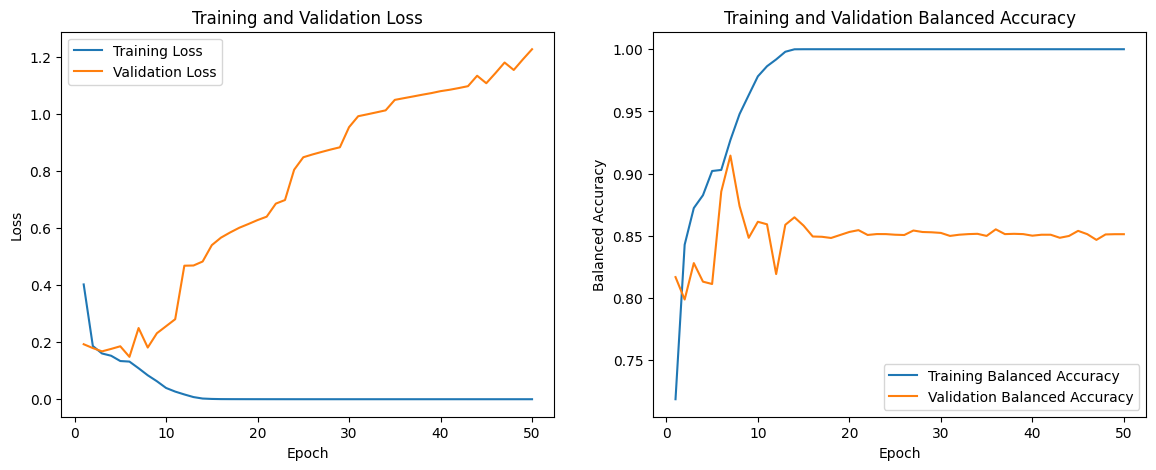

In [ ]:
# Visualization of losses and accuracies
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, tr_losses, label='Training Loss')
plt.plot(epochs_range, va_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_bal_accs, label='Training Balanced Accuracy')
plt.plot(epochs_range, val_bal_accs, label='Validation Balanced Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Balanced Accuracy')
plt.title('Training and Validation Balanced Accuracy')
plt.legend()

plt.show()

In [ ]:
save_path = '/content/drive/MyDrive/dlmi/submission.csv'
generate_predictions_and_save(model, test_loader, device, save_path)

Testing: 100%|██████████| 51/51 [01:23<00:00,  1.63s/it]


Test results saved to /content/drive/MyDrive/dlmi/submission.csv


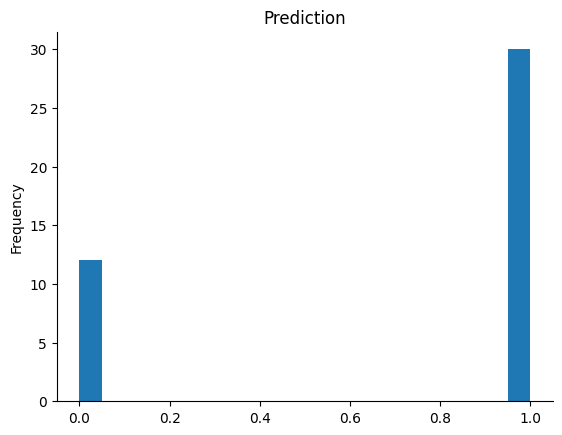

In [ ]:
from matplotlib import pyplot as plt
submission_df['Prediction'].plot(kind='hist', bins=20, title='Prediction')
plt.gca().spines[['top', 'right',]].set_visible(False)

# 3. improved models and Class Balancing Strategies
Here are some strategies to face class imabalance:

1- oversampling or undersamling the dataset:

2- use a weighted loss function


## Balancing Strategies


## Strategy 1. Oversample the minority class in the dataset__

In [ ]:
def get_class_distribution(dataset):
    counter = Counter()
    for _, label, _, _, _, _ in dataset:
        counter[label.item()] += 1
    return counter

def shuffle_dataset(dataset):
    indices = torch.randperm(len(dataset))
    return Subset(dataset, indices)

In [ ]:
dataset = MyDataset(data_dir=train_dir, transform=transform, Train=True)
test_set = MyDataset(data_dir=test_dir, transform=transform, Train=False)

# Initial class distribution
initial_distribution = get_class_distribution(dataset) #takes some time to run cz it iterates through the whole dataset, just used to create the figure later

# Splitting into class subsets
class_0_indices = [i for i, (_, label, _, _, _, _) in enumerate(dataset) if label == 0]
class_1_indices = [i for i, (_, label, _, _, _, _) in enumerate(dataset) if label == 1]

# Create class subsets
class_0_subset = Subset(dataset, class_0_indices)
class_1_subset = Subset(dataset, class_1_indices)

# Oversampling class_0 to balance
desired_size = len(class_1_indices)  #take teh size of the larger class
class_0_oversampled_indices = torch.randint(len(class_0_subset), (desired_size,), dtype=torch.long)
class_0_oversampled = Subset(class_0_subset, class_0_oversampled_indices)

# Combine into a balanced dataset
balanced_dataset = ConcatDataset([class_0_oversampled, class_1_subset])

balanced_dataset = shuffle_dataset(balanced_dataset)

# Class distribution after balancing
balanced_distribution = get_class_distribution(balanced_dataset)

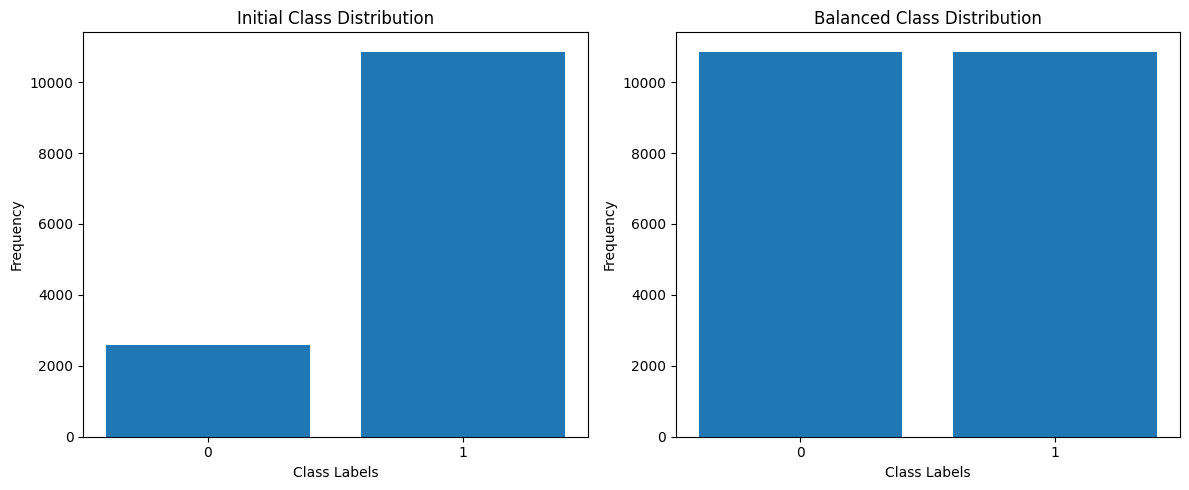

In [ ]:
# Visualization of class distributions before and after balancing
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].bar(initial_distribution.keys(), initial_distribution.values(), tick_label=list(initial_distribution.keys()))
axs[0].set_title('Initial Class Distribution')
axs[0].set_xlabel('Class Labels')
axs[0].set_ylabel('Frequency')
axs[0].set_xticks([0, 1])
axs[1].bar(balanced_distribution.keys(), balanced_distribution.values(), tick_label=list(balanced_distribution.keys()))
axs[1].set_title('Balanced Class Distribution')
axs[1].set_xlabel('Class Labels')
axs[1].set_ylabel('Frequency')
axs[1].set_xticks([0, 1])

plt.tight_layout()
plt.show()



In [ ]:
# Split dataset into train and validation sets
total_size = len(balanced_dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size
train_set, val_set = random_split(balanced_dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [ ]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using: {device}')
save_path = '/content/drive/MyDrive/dlmi/checkpoints/model_checkpoint_balanced_data.pth'

model = MyCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 40

using: cuda


In [ ]:
tr_losses, va_losses, train_bal_accs, val_bal_accs= train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs, save_path)

Validation: 100%|██████████| 67/67 [00:12<00:00,  5.20it/s]


Epoch 1/40, Train Loss: 0.4009, Validation Loss: 0.3573, Train Balanced Acc: 0.8082, Validation Balanced Acc: 0.8302
Validation Balanced Accuracy Improved (0.0000 --> 0.8302). Saving model ...


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.38it/s]


Epoch 2/40, Train Loss: 0.3103, Validation Loss: 0.3306, Train Balanced Acc: 0.8629, Validation Balanced Acc: 0.8198


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.30it/s]


Epoch 3/40, Train Loss: 0.2682, Validation Loss: 0.2165, Train Balanced Acc: 0.8878, Validation Balanced Acc: 0.9188
Validation Balanced Accuracy Improved (0.8302 --> 0.9188). Saving model ...


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.32it/s]


Epoch 4/40, Train Loss: 0.2447, Validation Loss: 0.2383, Train Balanced Acc: 0.8960, Validation Balanced Acc: 0.9142


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.27it/s]


Epoch 5/40, Train Loss: 0.2263, Validation Loss: 0.2841, Train Balanced Acc: 0.9065, Validation Balanced Acc: 0.8872


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.43it/s]


Epoch 6/40, Train Loss: 0.2167, Validation Loss: 0.2145, Train Balanced Acc: 0.9112, Validation Balanced Acc: 0.9142


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.40it/s]


Epoch 7/40, Train Loss: 0.2120, Validation Loss: 0.1995, Train Balanced Acc: 0.9121, Validation Balanced Acc: 0.9158


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.24it/s]


Epoch 8/40, Train Loss: 0.2057, Validation Loss: 0.1890, Train Balanced Acc: 0.9149, Validation Balanced Acc: 0.9124


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.38it/s]


Epoch 9/40, Train Loss: 0.1997, Validation Loss: 0.2133, Train Balanced Acc: 0.9191, Validation Balanced Acc: 0.9036


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.33it/s]


Epoch 10/40, Train Loss: 0.1963, Validation Loss: 0.3897, Train Balanced Acc: 0.9199, Validation Balanced Acc: 0.8612


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.41it/s]


Epoch 11/40, Train Loss: 0.1946, Validation Loss: 0.1853, Train Balanced Acc: 0.9191, Validation Balanced Acc: 0.9228
Validation Balanced Accuracy Improved (0.9188 --> 0.9228). Saving model ...


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.34it/s]


Epoch 12/40, Train Loss: 0.1919, Validation Loss: 0.1813, Train Balanced Acc: 0.9214, Validation Balanced Acc: 0.9259
Validation Balanced Accuracy Improved (0.9228 --> 0.9259). Saving model ...


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.46it/s]


Epoch 13/40, Train Loss: 0.1907, Validation Loss: 0.1761, Train Balanced Acc: 0.9210, Validation Balanced Acc: 0.9168


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.35it/s]


Epoch 14/40, Train Loss: 0.1871, Validation Loss: 0.1805, Train Balanced Acc: 0.9236, Validation Balanced Acc: 0.9267
Validation Balanced Accuracy Improved (0.9259 --> 0.9267). Saving model ...


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.42it/s]


Epoch 15/40, Train Loss: 0.1845, Validation Loss: 0.1740, Train Balanced Acc: 0.9242, Validation Balanced Acc: 0.9288
Validation Balanced Accuracy Improved (0.9267 --> 0.9288). Saving model ...


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.46it/s]


Epoch 16/40, Train Loss: 0.1779, Validation Loss: 0.1716, Train Balanced Acc: 0.9264, Validation Balanced Acc: 0.9299
Validation Balanced Accuracy Improved (0.9288 --> 0.9299). Saving model ...


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.55it/s]


Epoch 17/40, Train Loss: 0.1766, Validation Loss: 0.1751, Train Balanced Acc: 0.9277, Validation Balanced Acc: 0.9229


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.58it/s]


Epoch 18/40, Train Loss: 0.1766, Validation Loss: 0.1709, Train Balanced Acc: 0.9262, Validation Balanced Acc: 0.9288


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.52it/s]


Epoch 19/40, Train Loss: 0.1777, Validation Loss: 0.1670, Train Balanced Acc: 0.9253, Validation Balanced Acc: 0.9320
Validation Balanced Accuracy Improved (0.9299 --> 0.9320). Saving model ...


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.48it/s]


Epoch 20/40, Train Loss: 0.1741, Validation Loss: 0.1851, Train Balanced Acc: 0.9294, Validation Balanced Acc: 0.9167


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.37it/s]


Epoch 21/40, Train Loss: 0.1712, Validation Loss: 0.1877, Train Balanced Acc: 0.9288, Validation Balanced Acc: 0.9066


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.43it/s]


Epoch 22/40, Train Loss: 0.1702, Validation Loss: 0.1712, Train Balanced Acc: 0.9295, Validation Balanced Acc: 0.9256


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.49it/s]


Epoch 23/40, Train Loss: 0.1700, Validation Loss: 0.1778, Train Balanced Acc: 0.9293, Validation Balanced Acc: 0.9235


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.41it/s]


Epoch 24/40, Train Loss: 0.1671, Validation Loss: 0.1583, Train Balanced Acc: 0.9309, Validation Balanced Acc: 0.9344
Validation Balanced Accuracy Improved (0.9320 --> 0.9344). Saving model ...


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.46it/s]


Epoch 25/40, Train Loss: 0.1654, Validation Loss: 0.1650, Train Balanced Acc: 0.9311, Validation Balanced Acc: 0.9288


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.51it/s]


Epoch 26/40, Train Loss: 0.1622, Validation Loss: 0.1564, Train Balanced Acc: 0.9307, Validation Balanced Acc: 0.9374
Validation Balanced Accuracy Improved (0.9344 --> 0.9374). Saving model ...


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.36it/s]


Epoch 27/40, Train Loss: 0.1621, Validation Loss: 0.1594, Train Balanced Acc: 0.9323, Validation Balanced Acc: 0.9307


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.42it/s]


Epoch 28/40, Train Loss: 0.1633, Validation Loss: 0.2065, Train Balanced Acc: 0.9314, Validation Balanced Acc: 0.9205


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.27it/s]


Epoch 29/40, Train Loss: 0.1601, Validation Loss: 0.1581, Train Balanced Acc: 0.9342, Validation Balanced Acc: 0.9355


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.45it/s]


Epoch 30/40, Train Loss: 0.1616, Validation Loss: 0.1626, Train Balanced Acc: 0.9335, Validation Balanced Acc: 0.9295


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.43it/s]


Epoch 31/40, Train Loss: 0.1525, Validation Loss: 0.1768, Train Balanced Acc: 0.9361, Validation Balanced Acc: 0.9214


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.44it/s]


Epoch 32/40, Train Loss: 0.1569, Validation Loss: 0.1612, Train Balanced Acc: 0.9356, Validation Balanced Acc: 0.9328


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.44it/s]


Epoch 33/40, Train Loss: 0.1492, Validation Loss: 0.4071, Train Balanced Acc: 0.9382, Validation Balanced Acc: 0.8345


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.45it/s]


Epoch 34/40, Train Loss: 0.1597, Validation Loss: 0.1646, Train Balanced Acc: 0.9340, Validation Balanced Acc: 0.9260


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.40it/s]


Epoch 35/40, Train Loss: 0.1494, Validation Loss: 0.1657, Train Balanced Acc: 0.9378, Validation Balanced Acc: 0.9346


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.41it/s]


Epoch 36/40, Train Loss: 0.1494, Validation Loss: 0.1681, Train Balanced Acc: 0.9378, Validation Balanced Acc: 0.9288


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.43it/s]


Epoch 37/40, Train Loss: 0.1420, Validation Loss: 0.1423, Train Balanced Acc: 0.9415, Validation Balanced Acc: 0.9397
Validation Balanced Accuracy Improved (0.9374 --> 0.9397). Saving model ...


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.41it/s]


Epoch 38/40, Train Loss: 0.1405, Validation Loss: 0.1655, Train Balanced Acc: 0.9431, Validation Balanced Acc: 0.9248


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.43it/s]


Epoch 39/40, Train Loss: 0.1398, Validation Loss: 0.1326, Train Balanced Acc: 0.9430, Validation Balanced Acc: 0.9469
Validation Balanced Accuracy Improved (0.9397 --> 0.9469). Saving model ...


Validation: 100%|██████████| 67/67 [00:12<00:00,  5.39it/s]


Epoch 40/40, Train Loss: 0.1362, Validation Loss: 0.1835, Train Balanced Acc: 0.9461, Validation Balanced Acc: 0.9226


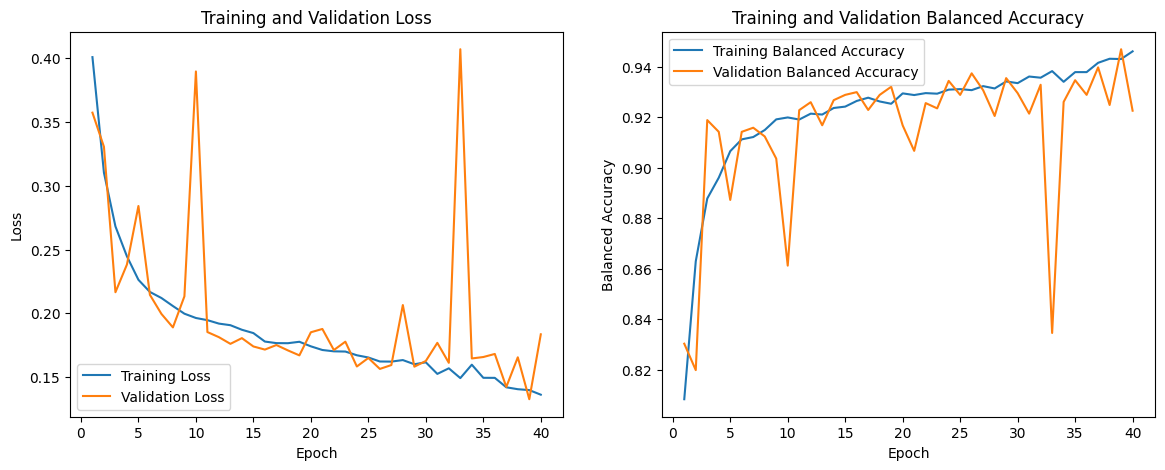

In [ ]:
# Visualization of losses and accuracies
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, tr_losses, label='Training Loss')
plt.plot(epochs_range, va_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_bal_accs, label='Training Balanced Accuracy')
plt.plot(epochs_range, val_bal_accs, label='Validation Balanced Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Balanced Accuracy')
plt.title('Training and Validation Balanced Accuracy')
plt.legend()

plt.show()

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/dlmi/checkpoints/model_checkpoint_balanced_data.pth' )

model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
save_path = '/content/drive/MyDrive/dlmi/submission_upsample.csv'
generate_predictions_and_save(model, test_loader, device, save_path)

Testing: 100%|██████████| 51/51 [00:09<00:00,  5.19it/s]

Test results saved to /content/drive/MyDrive/dlmi/submission_upsample.csv


## Strategy 2 __Undersampel class 1__ implies a loss of information:


In [ ]:

balanced_size = min(len(class_0_indices), len(class_1_indices))

# undersample class 1
class_0_oversampled_indices = torch.randint(len(class_0_subset), (balanced_size,), dtype=torch.long)
class_1_undersampled_indices = torch.randperm(len(class_1_subset))[:balanced_size]

class_0_oversampled = Subset(class_0_subset, class_0_oversampled_indices)
class_1_undersampled = Subset(class_1_subset, class_1_undersampled_indices)

# Combine 
balanced_dataset = ConcatDataset([class_0_oversampled, class_1_undersampled])

# Shuffle the balanced dataset
def shuffle_dataset(dataset):
    indices = torch.randperm(len(dataset))
    return Subset(dataset, indices)

balanced_dataset = shuffle_dataset(balanced_dataset)

# Class dist after balancing
balanced_distribution = get_class_distribution(DataLoader(balanced_dataset, batch_size=1, shuffle=False))

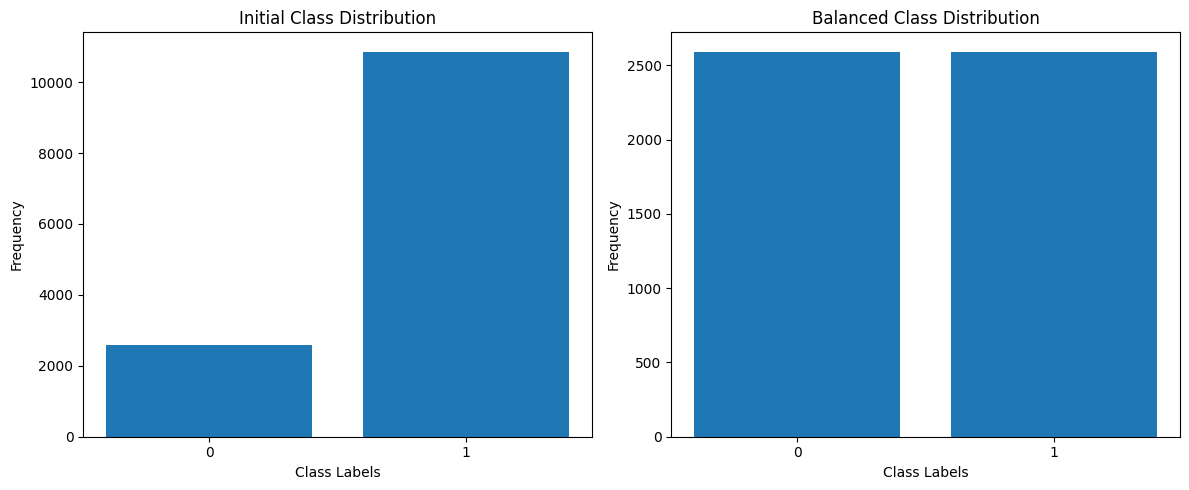

In [ ]:
# Visualization of class distributions before and after balancing
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].bar(initial_distribution.keys(), initial_distribution.values())
axs[0].set_title('Initial Class Distribution')
axs[0].set_xlabel('Class Labels')
axs[0].set_ylabel('Frequency')
axs[0].set_xticks([0, 1])
axs[1].bar(balanced_distribution.keys(), balanced_distribution.values())
axs[1].set_title('Balanced Class Distribution')
axs[1].set_xlabel('Class Labels')
axs[1].set_ylabel('Frequency')
axs[1].set_xticks([0, 1])

plt.tight_layout()
plt.show()

In [ ]:

total_size = len(balanced_dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size
train_set, val_set = random_split(balanced_dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [ ]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using: {device}')
save_path = '/content/drive/MyDrive/dlmi/checkpoints/model_checkpoint_balanced_data2.pth'

model = MyCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

num_epochs = 10

using: cuda


In [ ]:
tr_losses, va_losses, train_bal_accs, val_bal_accs= train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs, save_path)

Validation: 100%|██████████| 16/16 [00:02<00:00,  5.68it/s]


Epoch 1/10, Train Loss: 0.5469, Validation Loss: 0.4936, Train Balanced Acc: 0.8093, Validation Balanced Acc: 0.8156
Validation Balanced Accuracy Improved (0.0000 --> 0.8156). Saving model ...


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.58it/s]


Epoch 2/10, Train Loss: 0.4530, Validation Loss: 0.4259, Train Balanced Acc: 0.8592, Validation Balanced Acc: 0.9051
Validation Balanced Accuracy Improved (0.8156 --> 0.9051). Saving model ...


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.46it/s]


Epoch 3/10, Train Loss: 0.3974, Validation Loss: 0.3780, Train Balanced Acc: 0.8777, Validation Balanced Acc: 0.8882


Validation: 100%|██████████| 16/16 [00:03<00:00,  5.22it/s]


Epoch 4/10, Train Loss: 0.3561, Validation Loss: 0.3432, Train Balanced Acc: 0.8827, Validation Balanced Acc: 0.8933


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.47it/s]


Epoch 5/10, Train Loss: 0.3281, Validation Loss: 0.3196, Train Balanced Acc: 0.8828, Validation Balanced Acc: 0.8896


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.61it/s]


Epoch 6/10, Train Loss: 0.3088, Validation Loss: 0.3063, Train Balanced Acc: 0.8810, Validation Balanced Acc: 0.8886


Validation: 100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Epoch 7/10, Train Loss: 0.2956, Validation Loss: 0.2926, Train Balanced Acc: 0.8828, Validation Balanced Acc: 0.8917


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.47it/s]


Epoch 8/10, Train Loss: 0.2864, Validation Loss: 0.2851, Train Balanced Acc: 0.8818, Validation Balanced Acc: 0.8931


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.58it/s]


Epoch 9/10, Train Loss: 0.2777, Validation Loss: 0.2788, Train Balanced Acc: 0.8880, Validation Balanced Acc: 0.8942


Validation: 100%|██████████| 16/16 [00:03<00:00,  5.26it/s]

Epoch 10/10, Train Loss: 0.2720, Validation Loss: 0.2713, Train Balanced Acc: 0.8872, Validation Balanced Acc: 0.8862


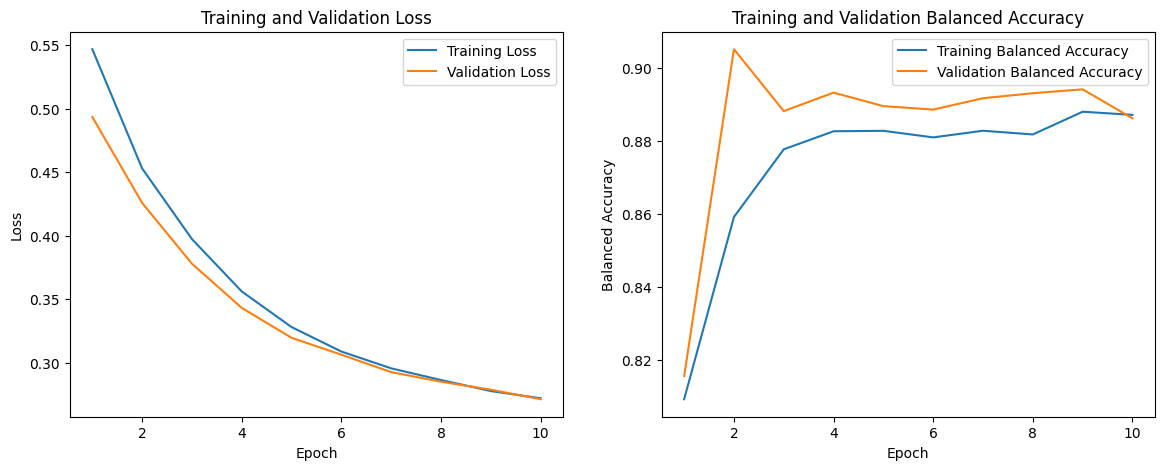

In [ ]:
# Visualization of losses and accuracies
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, tr_losses, label='Training Loss')
plt.plot(epochs_range, va_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_bal_accs, label='Training Balanced Accuracy')
plt.plot(epochs_range, val_bal_accs, label='Validation Balanced Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Balanced Accuracy')
plt.title('Training and Validation Balanced Accuracy')
plt.legend()

plt.show()

In [ ]:
save_path = '/content/drive/MyDrive/dlmi/submission_undersample.csv'
generate_predictions_and_save(model, test_loader, device, save_path)

Testing: 100%|██████████| 51/51 [00:09<00:00,  5.26it/s]

Test results saved to /content/drive/MyDrive/dlmi/submission_undersample.csv


These balancing tequiniques do not improve the performance of the baseline model

#Model2 - More Complex
##Try more convolutional layers on the mbaseline model and some data augmentation

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),  
    # transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=15),

])


In [ ]:
dataset= MyDataset(data_dir=train_dir, transform=transform, Train=True)
test_set= MyDataset(data_dir=test_dir, transform=transform, Train=False)

# Split dataset into train and validation sets
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, drop_last=True)
test_loader= DataLoader(test_set, batch_size=64, shuffle=False)

In [ ]:
class My_CNN2(nn.Module):
    def __init__(self, num_additional_features=3):
        super(My_CNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)#128
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)#64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)#32
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)#16

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(p=0.5) 

        self.fc1 = nn.Linear(256 * 16 * 16 + num_additional_features, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, images, additional_features):
        x = self.pool(F.relu(self.conv1(images)))
        x = self.dropout(x)  
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        x = torch.flatten(x, 1)

        x = torch.cat((x, additional_features), dim=1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))

        return x


In [ ]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using: {device}')
save_path = '/content/drive/MyDrive/dlmi/checkpoints/model_checkpoint_ali.pth'

model = My_CNN2().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

using: cuda


In [ ]:
tr_losses,va_losses, train_bal_accs, val_bal_accs= train_model(model, criterion,optimizer, train_loader, val_loader, device, num_epochs, save_path)

Validation: 100%|██████████| 42/42 [00:32<00:00,  1.27it/s]


Epoch 1/20, Train Loss: 0.2531, Validation Loss: 0.1704, Train Balanced Acc: 0.7458, Validation Balanced Acc: 0.8699
Validation Balanced Accuracy Improved (0.0000 --> 0.8699). Saving model ...


Validation: 100%|██████████| 42/42 [00:32<00:00,  1.28it/s]


Epoch 2/20, Train Loss: 0.1839, Validation Loss: 0.1661, Train Balanced Acc: 0.8431, Validation Balanced Acc: 0.8764
Validation Balanced Accuracy Improved (0.8699 --> 0.8764). Saving model ...


Validation: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]


Epoch 3/20, Train Loss: 0.1786, Validation Loss: 0.1669, Train Balanced Acc: 0.8481, Validation Balanced Acc: 0.8764


Validation: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]


Epoch 4/20, Train Loss: 0.1737, Validation Loss: 0.1660, Train Balanced Acc: 0.8560, Validation Balanced Acc: 0.8679


Validation: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]


Epoch 5/20, Train Loss: 0.1721, Validation Loss: 0.1656, Train Balanced Acc: 0.8547, Validation Balanced Acc: 0.8681


Validation: 100%|██████████| 42/42 [00:31<00:00,  1.31it/s]


Epoch 6/20, Train Loss: 0.1721, Validation Loss: 0.1693, Train Balanced Acc: 0.8510, Validation Balanced Acc: 0.8961
Validation Balanced Accuracy Improved (0.8764 --> 0.8961). Saving model ...


Validation: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]


Epoch 7/20, Train Loss: 0.1661, Validation Loss: 0.1633, Train Balanced Acc: 0.8648, Validation Balanced Acc: 0.8793


Validation: 100%|██████████| 42/42 [00:32<00:00,  1.28it/s]


Epoch 8/20, Train Loss: 0.1638, Validation Loss: 0.1665, Train Balanced Acc: 0.8659, Validation Balanced Acc: 0.8939


Validation: 100%|██████████| 42/42 [00:32<00:00,  1.28it/s]


Epoch 9/20, Train Loss: 0.1635, Validation Loss: 0.1610, Train Balanced Acc: 0.8706, Validation Balanced Acc: 0.8889


Validation: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]


Epoch 10/20, Train Loss: 0.1674, Validation Loss: 0.1606, Train Balanced Acc: 0.8603, Validation Balanced Acc: 0.8929


Validation: 100%|██████████| 42/42 [00:30<00:00,  1.36it/s]


Epoch 11/20, Train Loss: 0.1642, Validation Loss: 0.1618, Train Balanced Acc: 0.8663, Validation Balanced Acc: 0.8573


Validation: 100%|██████████| 42/42 [00:31<00:00,  1.31it/s]


Epoch 12/20, Train Loss: 0.1598, Validation Loss: 0.1639, Train Balanced Acc: 0.8752, Validation Balanced Acc: 0.9043
Validation Balanced Accuracy Improved (0.8961 --> 0.9043). Saving model ...


Validation: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]


Epoch 13/20, Train Loss: 0.1597, Validation Loss: 0.1581, Train Balanced Acc: 0.8761, Validation Balanced Acc: 0.8964


Validation: 100%|██████████| 42/42 [00:31<00:00,  1.33it/s]


Epoch 14/20, Train Loss: 0.1621, Validation Loss: 0.1642, Train Balanced Acc: 0.8689, Validation Balanced Acc: 0.8482


Validation: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]


Epoch 15/20, Train Loss: 0.1631, Validation Loss: 0.1591, Train Balanced Acc: 0.8593, Validation Balanced Acc: 0.8720


Validation: 100%|██████████| 42/42 [00:31<00:00,  1.34it/s]


Epoch 16/20, Train Loss: 0.1567, Validation Loss: 0.1586, Train Balanced Acc: 0.8696, Validation Balanced Acc: 0.8741


Validation: 100%|██████████| 42/42 [00:31<00:00,  1.33it/s]


Epoch 17/20, Train Loss: 0.1610, Validation Loss: 0.2114, Train Balanced Acc: 0.8638, Validation Balanced Acc: 0.7454


Validation: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]


Epoch 18/20, Train Loss: 0.1561, Validation Loss: 0.1614, Train Balanced Acc: 0.8663, Validation Balanced Acc: 0.8319


Validation: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]


Epoch 19/20, Train Loss: 0.1538, Validation Loss: 0.1525, Train Balanced Acc: 0.8796, Validation Balanced Acc: 0.8941


Validation: 100%|██████████| 42/42 [00:32<00:00,  1.29it/s]

Epoch 20/20, Train Loss: 0.1589, Validation Loss: 0.1568, Train Balanced Acc: 0.8642, Validation Balanced Acc: 0.8712


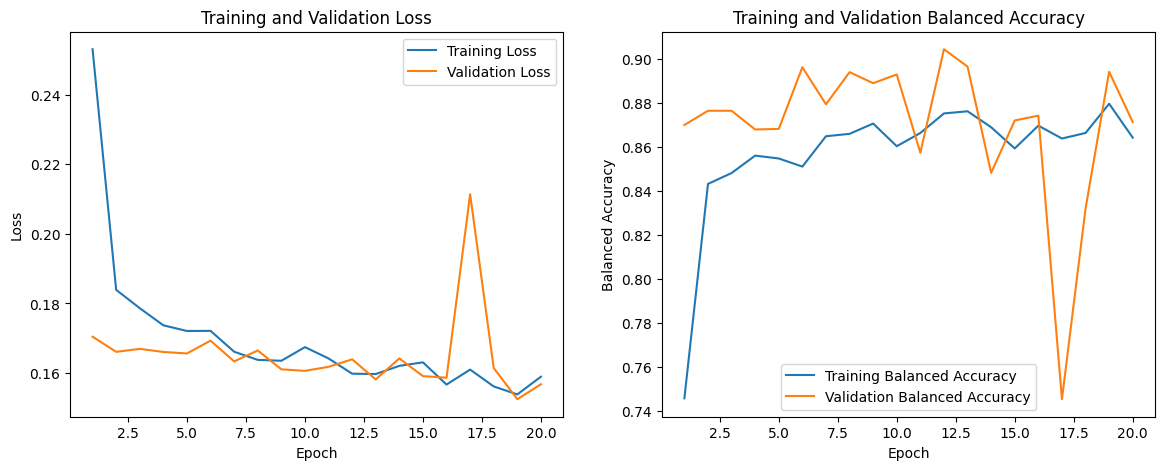

In [ ]:
# Visualization of losses and accuracies
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, tr_losses, label='Training Loss')
plt.plot(epochs_range, va_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_bal_accs, label='Training Balanced Accuracy')
plt.plot(epochs_range, val_bal_accs, label='Validation Balanced Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Balanced Accuracy')
plt.title('Training and Validation Balanced Accuracy')
plt.legend()

plt.show()

In [ ]:
save_path = '/content/drive/MyDrive/dlmi/submission_ALI.csv'
generate_predictions_and_save(model, test_loader, device, save_path)

# __ViT based classifier (Model3)__:
Get a pretrained classifier and fien tune it usign AdaptFormer seen in class

In [ ]:
class AdaptFormer(nn.Module):
    def __init__(self, layer_norm, linear, activation='ReLU', reduction_factor=8):
        super(AdaptFormer, self).__init__()
        self.layer_norm = layer_norm
        self.linear = linear
        self.adapter_alpha = nn.Parameter(torch.ones(1))

        hidden_dim = self.linear.fc1.in_features//reduction_factor
        self.adapter_downsample = nn.Linear(self.linear.fc1.in_features, hidden_dim)
        self.activation = getattr(nn, activation)()
        self.adapter_upsample = nn.Linear(hidden_dim, self.linear.fc1.in_features)

    def forward(self, x):
        main_x = self.linear(self.layer_norm(x))
        adapted_x = self.adapter_upsample(self.activation(self.adapter_downsample(x))) * self.adapter_alpha
        return main_x + adapted_x

def add_adaptformer(model):
    for encoder_block in model.blocks:
        encoder_block.mlp = AdaptFormer(encoder_block.norm2, encoder_block.mlp)
        encoder_block.norm2 = nn.Identity()

def freeze_model_adaptformer(model):
    for name, param in model.named_parameters():
        if not 'adapter' in name:
            param.requires_grad = False

class DinoV2WithFeatures(nn.Module):
    def __init__(self, dino_model, num_classes, num_additional_features, hidden_dim=128):
        super().__init__()
        self.dino_model = dino_model
        self.num_features = dino_model.embed_dim
        self.fc1 = nn.Linear(self.num_features + num_additional_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc3 = nn.Linear(hidden_dim//2, num_classes)
        self.relu = nn.ReLU()
        self.sigmoid= nn.Sigmoid()

    def forward(self, images, additional_features):
        # Get the features from DINO v2 [CLS] token
        features = self.dino_model(images)

        # Concatenate DINO v2 features with the additional features
        combined_features = torch.cat((features, additional_features), dim=1)

        # Classification
        x = self.fc1(combined_features)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        out = self.fc3(x)
        # out = self.sigmoid(out)
        return out

In [ ]:
import torch.hub

# Load DINO v2
model_type='vits'
model2 = torch.hub.load('facebookresearch/dinov2', f'dinov2_{model_type}14')

# Apply AdaptFormer to the DINO v2 model
add_adaptformer(model2)
freeze_model_adaptformer(model2)


num_additional_features = 3  
num_classes = 1 
combined_model = DinoV2WithFeatures(model2, num_classes, num_additional_features)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [ ]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


dataset = MyDataset(data_dir=train_dir, transform=transform, Train=True)

dataset= MyDataset(data_dir=train_dir, transform=transform, Train=True)
test_set= MyDataset(data_dir=test_dir, transform=transform, Train=False)

# Split dataset into train and validation sets
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, drop_last=True)
test_loader= DataLoader(test_set, batch_size=64, shuffle=False)

In [ ]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using: {device}')
save_path = '/content/drive/MyDrive/dlmi/checkpoints/model_checkpoint_adapted_vit_2.pth'

model = combined_model.to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

num_epochs = 40

using: cuda


In [ ]:
class_counts = {0: 50, 1: 113}
total = sum(class_counts.values())
class_weights = {cls: total / count for cls, count in class_counts.items()}
weights = torch.tensor([class_weights[0], class_weights[1]], dtype=torch.float32)
# Move weights to the same device as your model
weights = weights.to(device)

# Setup the loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=weights[1])


In [ ]:
tr_losses, va_losses, train_bal_accs, val_bal_accs= train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs, save_path)

Validation: 100%|██████████| 42/42 [00:07<00:00,  5.56it/s]


Epoch 1/40, Train Loss: 0.3939, Validation Loss: 0.3708, Train Balanced Acc: 0.5606, Validation Balanced Acc: 0.6418
Validation Balanced Accuracy Improved (0.0000 --> 0.6418). Saving model ...


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.62it/s]


Epoch 2/40, Train Loss: 0.3508, Validation Loss: 0.3347, Train Balanced Acc: 0.6941, Validation Balanced Acc: 0.7204
Validation Balanced Accuracy Improved (0.6418 --> 0.7204). Saving model ...


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.54it/s]


Epoch 3/40, Train Loss: 0.3210, Validation Loss: 0.3074, Train Balanced Acc: 0.7480, Validation Balanced Acc: 0.7995
Validation Balanced Accuracy Improved (0.7204 --> 0.7995). Saving model ...


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.60it/s]


Epoch 4/40, Train Loss: 0.2991, Validation Loss: 0.2881, Train Balanced Acc: 0.7860, Validation Balanced Acc: 0.7995


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.62it/s]


Epoch 5/40, Train Loss: 0.2830, Validation Loss: 0.2734, Train Balanced Acc: 0.8021, Validation Balanced Acc: 0.8166
Validation Balanced Accuracy Improved (0.7995 --> 0.8166). Saving model ...


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.55it/s]


Epoch 6/40, Train Loss: 0.2711, Validation Loss: 0.2613, Train Balanced Acc: 0.8209, Validation Balanced Acc: 0.8238
Validation Balanced Accuracy Improved (0.8166 --> 0.8238). Saving model ...


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.68it/s]


Epoch 7/40, Train Loss: 0.2612, Validation Loss: 0.2522, Train Balanced Acc: 0.8224, Validation Balanced Acc: 0.8276
Validation Balanced Accuracy Improved (0.8238 --> 0.8276). Saving model ...


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.59it/s]


Epoch 8/40, Train Loss: 0.2545, Validation Loss: 0.2452, Train Balanced Acc: 0.8251, Validation Balanced Acc: 0.8290
Validation Balanced Accuracy Improved (0.8276 --> 0.8290). Saving model ...


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.64it/s]


Epoch 9/40, Train Loss: 0.2481, Validation Loss: 0.2396, Train Balanced Acc: 0.8309, Validation Balanced Acc: 0.8334
Validation Balanced Accuracy Improved (0.8290 --> 0.8334). Saving model ...


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.61it/s]


Epoch 10/40, Train Loss: 0.2437, Validation Loss: 0.2348, Train Balanced Acc: 0.8300, Validation Balanced Acc: 0.8332


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.65it/s]


Epoch 11/40, Train Loss: 0.2394, Validation Loss: 0.2356, Train Balanced Acc: 0.8305, Validation Balanced Acc: 0.8291


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.62it/s]


Epoch 12/40, Train Loss: 0.2361, Validation Loss: 0.2267, Train Balanced Acc: 0.8318, Validation Balanced Acc: 0.8242


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.69it/s]


Epoch 13/40, Train Loss: 0.2323, Validation Loss: 0.2241, Train Balanced Acc: 0.8336, Validation Balanced Acc: 0.8306


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.65it/s]


Epoch 14/40, Train Loss: 0.2299, Validation Loss: 0.2209, Train Balanced Acc: 0.8354, Validation Balanced Acc: 0.8306


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.68it/s]


Epoch 15/40, Train Loss: 0.2270, Validation Loss: 0.2185, Train Balanced Acc: 0.8368, Validation Balanced Acc: 0.8431
Validation Balanced Accuracy Improved (0.8334 --> 0.8431). Saving model ...


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.59it/s]


Epoch 16/40, Train Loss: 0.2254, Validation Loss: 0.2187, Train Balanced Acc: 0.8363, Validation Balanced Acc: 0.8327


Validation: 100%|██████████| 42/42 [00:08<00:00,  5.20it/s]


Epoch 17/40, Train Loss: 0.2232, Validation Loss: 0.2138, Train Balanced Acc: 0.8376, Validation Balanced Acc: 0.8399


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.72it/s]


Epoch 18/40, Train Loss: 0.2201, Validation Loss: 0.2174, Train Balanced Acc: 0.8430, Validation Balanced Acc: 0.8336


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.70it/s]


Epoch 19/40, Train Loss: 0.2194, Validation Loss: 0.2118, Train Balanced Acc: 0.8418, Validation Balanced Acc: 0.8306


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.66it/s]


Epoch 20/40, Train Loss: 0.2178, Validation Loss: 0.2094, Train Balanced Acc: 0.8432, Validation Balanced Acc: 0.8413


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.72it/s]


Epoch 21/40, Train Loss: 0.2158, Validation Loss: 0.2098, Train Balanced Acc: 0.8464, Validation Balanced Acc: 0.8306


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.67it/s]


Epoch 22/40, Train Loss: 0.2147, Validation Loss: 0.2059, Train Balanced Acc: 0.8486, Validation Balanced Acc: 0.8556
Validation Balanced Accuracy Improved (0.8431 --> 0.8556). Saving model ...


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.66it/s]


Epoch 23/40, Train Loss: 0.2133, Validation Loss: 0.2051, Train Balanced Acc: 0.8540, Validation Balanced Acc: 0.8646
Validation Balanced Accuracy Improved (0.8556 --> 0.8646). Saving model ...


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.71it/s]


Epoch 24/40, Train Loss: 0.2124, Validation Loss: 0.2042, Train Balanced Acc: 0.8501, Validation Balanced Acc: 0.8536


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.66it/s]


Epoch 25/40, Train Loss: 0.2114, Validation Loss: 0.2021, Train Balanced Acc: 0.8550, Validation Balanced Acc: 0.8640


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.70it/s]


Epoch 26/40, Train Loss: 0.2101, Validation Loss: 0.2025, Train Balanced Acc: 0.8569, Validation Balanced Acc: 0.8550


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.71it/s]


Epoch 27/40, Train Loss: 0.2093, Validation Loss: 0.2006, Train Balanced Acc: 0.8599, Validation Balanced Acc: 0.8556


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.66it/s]


Epoch 28/40, Train Loss: 0.2075, Validation Loss: 0.2078, Train Balanced Acc: 0.8594, Validation Balanced Acc: 0.8357


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.70it/s]


Epoch 29/40, Train Loss: 0.2064, Validation Loss: 0.1983, Train Balanced Acc: 0.8624, Validation Balanced Acc: 0.8658
Validation Balanced Accuracy Improved (0.8646 --> 0.8658). Saving model ...


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.66it/s]


Epoch 30/40, Train Loss: 0.2067, Validation Loss: 0.2031, Train Balanced Acc: 0.8636, Validation Balanced Acc: 0.8684
Validation Balanced Accuracy Improved (0.8658 --> 0.8684). Saving model ...


Validation: 100%|██████████| 42/42 [00:07<00:00,  5.68it/s]


Epoch 31/40, Train Loss: 0.2054, Validation Loss: 0.1974, Train Balanced Acc: 0.8655, Validation Balanced Acc: 0.8593


Training:  11%|█▏        | 19/168 [00:05<00:42,  3.54it/s]


KeyboardInterrupt: 

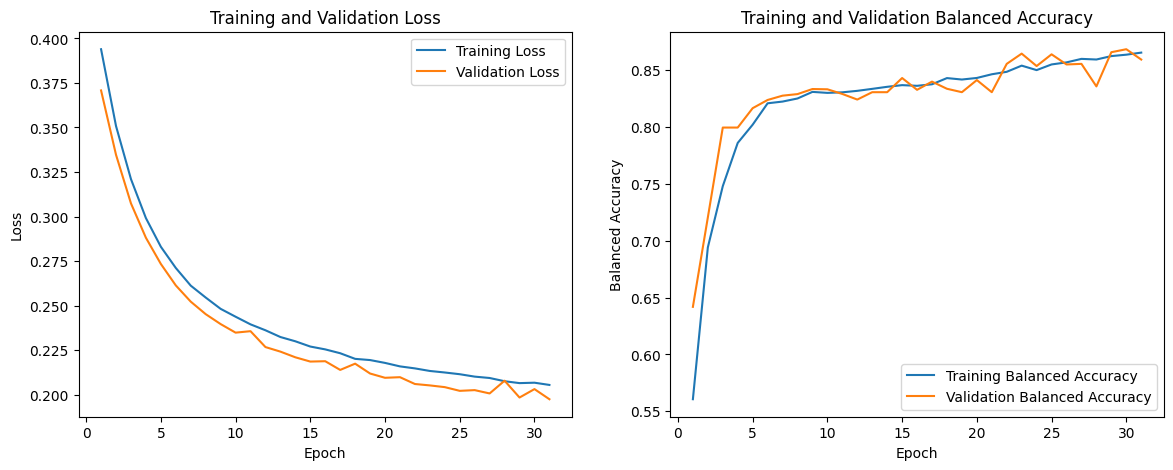

In [ ]:
# Visualization of losses and accuracies
epochs_range = range(1, 31 + 1)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, tr_losses, label='Training Loss')
plt.plot(epochs_range, va_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_bal_accs, label='Training Balanced Accuracy')
plt.plot(epochs_range, val_bal_accs, label='Validation Balanced Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Balanced Accuracy')
plt.title('Training and Validation Balanced Accuracy')
plt.legend()

plt.show()

In [ ]:
checkpoint = torch.load(save_path)
model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
save_path = '/content/drive/MyDrive/dlmi/submission_balanced_vit_4.csv'
generate_predictions_and_save(model, test_loader, device, save_path)

Testing: 100%|██████████| 51/51 [00:08<00:00,  5.73it/s]


Test results saved to /content/drive/MyDrive/dlmi/submission_balanced_vit_4.csv
